<h1 style="color:tomato;text-align:center;font-size:300%;font-family:verdana;"> Customer Segmentation Project</h1>

We are an online company and we have dataset containing online sales.<br>
We want to segment our customers to groups to give them targeted commercials.<br> 

My Goal in this project is to find the best customer segmentation.

### METHODS

**in this project i will use differents method listed below with an explanation**

- `EDA`: since we want to learn about the customer in order to get better result it is imperative to understand the data. the eda step will introduce us to the data and the behaviour (distribution and more) but also since we having dateType feature i will also use some timeseries method to get some information about the purchases abbit time wise
- `PREPROCESSING` : after understanding the data some of the feature will need some preparation like droping,cleaning,transformation,and of course outliers
- `FEATURE ENGINEERING` is a key step that might lead to good result (new feature based on the data so we can use the new df instead of the source
- `MODELING`: after all th steps mentined above i will implement some algo (diffeent) and check for the algorithm that lead to better overall reesult 
- `CONCLUSION` : the last but most important step will be to conclude our result and why.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
sns.set_theme(style="darkgrid")
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### data import 

In [3]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

### sample of the data

In [4]:
df.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
57561,541213,22131,FOOD CONTAINER SET 3 LOVE HEART,3,14-01-2011 13:28,1.95,15033.0,United Kingdom
399232,571274,22294,HEART FILIGREE DOVE SMALL,24,16-10-2011 12:25,1.25,16934.0,United Kingdom
284758,561885,21636,MADRAS NOTEBOOK MEDIUM,12,31-07-2011 13:13,0.75,15532.0,United Kingdom


### shape of the data

In [5]:
df.shape

(541909, 8)

---
# Exploratory Data Analysis

###  info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### descriptive statistics

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


### checking missing data - percentage-wise

In [8]:
missing = df.isnull().mean() * 100
missing[missing != 0]

Description     0.268311
CustomerID     24.926694
dtype: float64

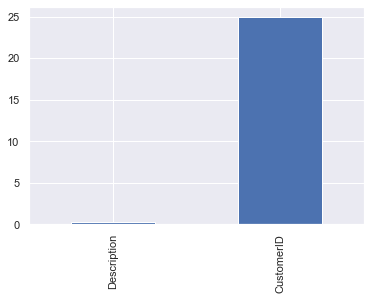

In [9]:
missing[missing != 0].plot(kind = 'bar');

In [77]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]

### Drop the null values

In [10]:
df.dropna(inplace=True)

In [11]:
assert(df.isna().sum().sum() == 0)

In [12]:
df.shape

(406829, 8)

### VISUALIZATION (TIME)

In [13]:
dftime = df.copy()

In [14]:
dftime['InvoiceDate'] = pd.to_datetime(dftime['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
dftime['total amount spent'] = dftime['Quantity'] * dftime['UnitPrice']

In [16]:
spend_time = dftime.groupby('InvoiceDate')['total amount spent'].sum()
spend_time = spend_time.reset_index()
spend_time.columns = ['date', 'Total']

In [17]:
spend_time.index =  spend_time["date"]

In [18]:
df_month = spend_time.resample('M').mean()
df_week = spend_time.resample('W').mean()
df_day = spend_time.resample('D').mean()

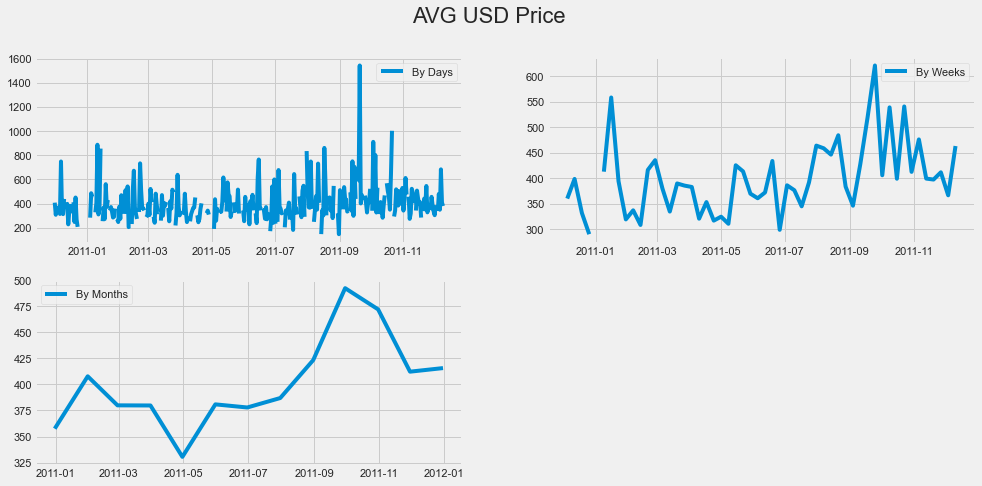

In [70]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('AVG USD Price', fontsize=22)

plt.subplot(221)
plt.plot(df_day['Total'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_week['Total'], '-', label='By Weeks')
plt.legend()

plt.subplot(223)
plt.plot(df_month['Total'], '-', label='By Months')
plt.legend()

plt.show()

#### we can observe higher sale start from september till end of the year when the pick is in october 
- might make sense since in october we will found haloween and many other celebration days and the data is from retailer that sale small occasional gifts

___
# Feature Engineering

### in order to understand better the data i will add new features

- totalSpend: total amount spend in each transaction (quantity*piece price)
- totalTransaction: the total amount of transaction by customer
- diff: the time between purchase

adding new feature are very important for segmentation if my goal is to target better my customers

#### PREPARATION
some preparations needed in order to create correct and accurate features
- change dtype for feature (dateTime)
- reorder the feature by the date and customer so when we apply the diff() we get the result in correct order
- we will compute the max date so we get the last purchase date 

In [20]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [21]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

### Change the invoice date to a datetime type
format='%d-%m-%Y %H:%M'

In [22]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

### total amount spent
quantity * unit price

In [23]:
df['total amount spent'] = df['Quantity'] * df['UnitPrice']

### Sum the total amount spent per customer 

In [24]:
spend_df = df.groupby('CustomerID')['total amount spent'].sum()
spend_df = spend_df.reset_index()

### Count the invoice numbers per customer

In [25]:
invoice_id = df.groupby('CustomerID')['InvoiceNo'].count()
invoice_id = invoice_id.reset_index()
invoice_id.columns = ['CustomerID', 'Total invoice']

### create time between purchase for customer and save only the days(so i remain only with int)

In [26]:
m_date = df['InvoiceDate'].max()

In [27]:
df['last diff'] = m_date - df['InvoiceDate']
df['last diff'] = [i.days for i in df['last diff']]

In [28]:
df.sample(3).T

,84135,506501,70726
InvoiceNo,543370,579143,542100
StockCode,22860,21484,22951
Description,EASTER TIN CHICKS PINK DAISY,CHICK GREY HOT WATER BOTTLE,60 CAKE CASES DOLLY GIRL DESIGN
Quantity,6,4,3
InvoiceDate,2011-02-07 14:51:00,2011-11-28 13:08:00,2011-01-25 13:15:00
UnitPrice,1.65,4.25,0.55
CustomerID,12359,13882,15339
Country,Cyprus,United Kingdom,United Kingdom
total amount spent,9.9,17,1.65
last diff,304,10,317


### create minimum time between purchase for customer and save only the days(so i remain only with int)

In [29]:
min_time = df.groupby('CustomerID')['last diff'].min()
min_time = min_time.reset_index()

### concate  df's and display the result

In [30]:
df2 = pd.merge(spend_df, invoice_id, on='CustomerID', how='inner')
df2 = pd.merge(df2, min_time, on='CustomerID', how='inner')

In [31]:
df2.sample(3)

,CustomerID,total amount spent,Total invoice,last diff
2297,15452,538.73,58,29
2311,15469,504.50,27,42
2724,16031,548.94,100,91


In [32]:
assert(df2.isna().sum().sum()==0)

In [33]:
df2.shape

(4372, 4)

In [75]:
for i in ['total amount spent','Total invoice','last diff']:
    print(f'{i}:')
    print(df2[i].min())
    print(df2[i].max())    
    print('*'*10)

total amount spent:
-4287.63
279489.0199999999
**********
Total invoice:
1
7983
**********
last diff:
0
373
**********


### SCALING

- before moving forward on the process, since we having different range of number we want to scale the data, but **why ?**
- 2 reasons:`1st` if we want to compare we have to give them a common scale .                                               `2nd` but very important, kmeans use distance metrics in order to compute the cluster so if we dont want to get an incorrect result due to incorrect value we want to rescal the value then to feed the algo with the new values
- we will not scale the customerId since its not needed
- after we scale the data we will get an array of values so we will create a new df from the result in order to work with 

In [35]:
scaling_cols = df2[['total amount spent', 'Total invoice', 'last diff']]

In [36]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(scaling_cols)

In [37]:
# create df from arrray result
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = ['total amount spent', 'Total invoice', 'last diff']

In [38]:
scaled_df.sample(3)

,total amount spent,Total invoice,last diff
403,-0.194528,-0.314282,1.964717
3460,-0.105656,-0.279865,-0.060019
1236,-0.147538,-0.211032,1.051601


___
# Segmentation

### Print a boxplot to check for outliers

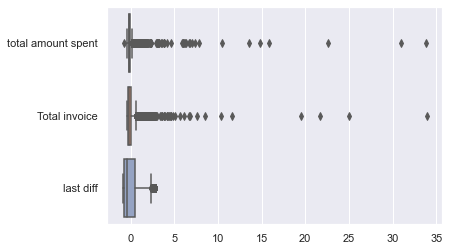

In [39]:
ax = sns.boxplot(data=scaled_df, orient="h", palette="Set2")

### i will be using Tukey's rule for finding outliers for each feature

In [40]:
import numpy as np
from collections import Counter
def detect_outliers(df, n, features):
    outlier_indices = []
    # iterate over features list
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 1 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

# detect outliers from list of features
lof = ['total amount spent', 'Total invoice', 'last diff']
Outliers_to_drop = detect_outliers(scaled_df, 1, lof)

### Print the outliers that are repeating on more the one feature

In [41]:
Outliers_to_drop

[12,
 15,
 55,
 66,
 69,
 71,
 86,
 100,
 101,
 103,
 105,
 106,
 112,
 115,
 154,
 156,
 157,
 178,
 191,
 226,
 231,
 232,
 238,
 261,
 276,
 277,
 278,
 290,
 295,
 298,
 302,
 308,
 318,
 330,
 331,
 334,
 338,
 344,
 393,
 395,
 413,
 450,
 479,
 487,
 507,
 510,
 521,
 543,
 556,
 561,
 564,
 568,
 575,
 576,
 579,
 587,
 595,
 605,
 638,
 657,
 698,
 703,
 740,
 803,
 809,
 836,
 843,
 859,
 899,
 942,
 988,
 1005,
 1016,
 1062,
 1078,
 1136,
 1206,
 1219,
 1221,
 1251,
 1266,
 1273,
 1274,
 1293,
 1295,
 1300,
 1345,
 1348,
 1363,
 1367,
 1368,
 1370,
 1437,
 1442,
 1447,
 1466,
 1495,
 1510,
 1528,
 1537,
 1599,
 1614,
 1615,
 1621,
 1633,
 1645,
 1674,
 1703,
 1720,
 1728,
 1733,
 1782,
 1794,
 1813,
 1816,
 1846,
 1883,
 1895,
 1911,
 1926,
 1953,
 1966,
 1976,
 1980,
 1984,
 1999,
 2013,
 2072,
 2073,
 2079,
 2099,
 2102,
 2146,
 2186,
 2192,
 2227,
 2245,
 2329,
 2331,
 2341,
 2355,
 2368,
 2375,
 2385,
 2408,
 2420,
 2438,
 2498,
 2505,
 2548,
 2562,
 2563,
 2603,
 2613,


### based on the method above i will be droping all the indices that were found as outlier

In [42]:
len(Outliers_to_drop)

238

In [43]:
scaled_df.shape

(4372, 3)

In [44]:
new_df = scaled_df.copy()

In [45]:
new_df.drop(Outliers_to_drop,inplace=True)

In [46]:
new_df.shape

(4134, 3)

___
# Clustering

### i will the Elbow Method to choose the number of clusters

#### some PREP needed before implementing on the full dataset
- since the invoice is not a number but an object i will change it to a 'str' so the algo could read it 

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.mixture import GaussianMixture

In [48]:
sse = []
silouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(new_df)
    sse.append(kmeans.inertia_)
    score = silhouette_score(new_df, kmeans.labels_, metric='euclidean')
    silouette.append(score)

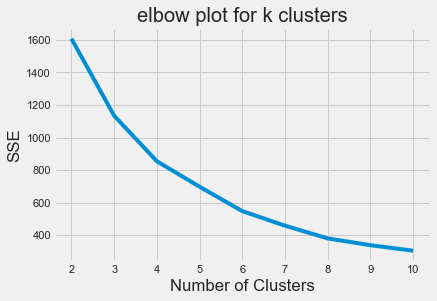

In [49]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('elbow plot for k clusters')
plt.show()

- Based on the elbow plot the optimal k is **4**

### silhouette score of the kmeans algorithm

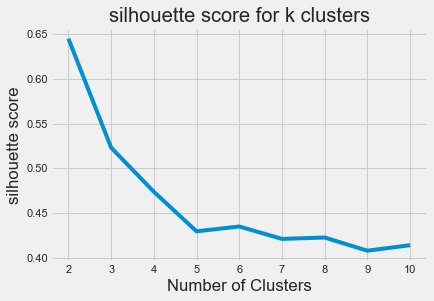

In [50]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silouette)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette score")
plt.title('silhouette score for k clusters')
plt.show()

In [78]:
silouette[1]

0.5230347130092684

### silhouette score of the Gaussian Mixture algorithm

In [52]:
gm_bic= []
gm_score=[]
for i in range(2,11):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(new_df)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(new_df)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(new_df)))
    print("-"*100)
    gm_bic.append(-gm.bic(new_df))
    gm_score.append(gm.score(new_df))

BIC for number of cluster(s) 2: 1310.9860549085006
Log-likelihood score for number of cluster(s) 2: -0.13942586367246107
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: -2416.695772956105
Log-likelihood score for number of cluster(s) 3: 0.3215020312558194
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: -3965.6319749015856
Log-likelihood score for number of cluster(s) 4: 0.5189144900545491
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: -4980.983450193456
Log-likelihood score for number of cluster(s) 5: 0.6517908183920295
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: -5542.175485036202
Log-likelihood score for number of cluster(s) 6: 0.729737364382010

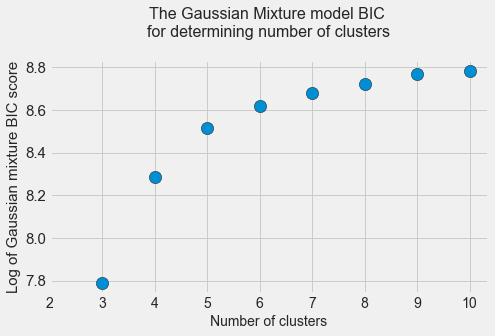

In [53]:
plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,11)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,11)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

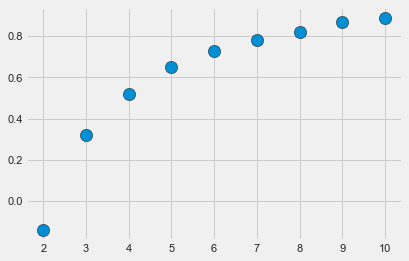

In [54]:
plt.scatter(x=[i for i in range(2,11)],y=gm_score,s=150,edgecolor='k')
plt.show()

### Dendrogram method to choose the number of clusters

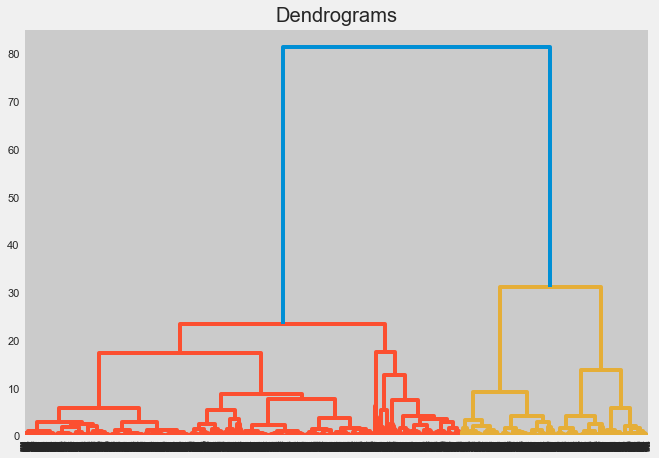

In [55]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(new_df, method='ward'))

- by the dendogram we can mentioned that the optimal k is : **2**

___
# Apply to data

### Instantiate the KMeans model with the number of clusters you found, fit and predict

In [56]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(new_df)

KMeans(n_clusters=4, random_state=42)

###  cluster's centers?

In [57]:
kmeans.cluster_centers_

array([[ 0.21728774,  0.49998813, -0.70529303],
       [-0.18270135, -0.30176112,  2.03915541],
       [-0.12347347, -0.19124258, -0.53895275],
       [-0.15102598, -0.23842404,  0.66716824]])

In [58]:
new_df['Cluster_kmeans'] = kmeans.labels_
new_df.head()

,total amount spent,Total invoice,last diff,Cluster_kmeans
0,-0.231001,-0.391720,2.322023,1
1,0.293432,0.382657,-0.893733,0
2,-0.012316,-0.266959,-0.169196,2
3,-0.017146,-0.086271,-0.725005,2
4,-0.190312,-0.327188,2.163220,1


### Which algorithm is better?


- the best algorithm (based on the silhouette score) is `Gaussian Mixture algorithm` with a silhouette score of **0.726**

- `silhouette score` score are between [-1,1]- the higher the score the more the cluster are ddense and have better separation since the score is base on how much each point in the cluster is similar to his fellow point in the same cluster **but** also how different they are from the other clusters.

**the reasons why Gaussian Mixture algorithm have higher result**

- `GMM` do take in consideration the variance while `k-means` do not account for variance
- `k-means` tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters

- for the reason mentioned above i decided to use `GMM` ove `k-means` 

In [59]:
gmm = GaussianMixture(n_components=4)
gmm.fit(scaled_df)
labels = gmm.predict(scaled_df)

In [60]:
labels_frame = pd.DataFrame(labels,columns=['cluster'])

In [61]:
new_df['Cluster_gmm'] = labels_frame['cluster']

In [62]:
new_df

,total amount spent,Total invoice,last diff,Cluster_kmeans,Cluster_gmm
0,-0.231001,-0.391720,2.322023,1,1
1,0.293432,0.382657,-0.893733,0,0
2,-0.012316,-0.266959,-0.169196,2,0
3,-0.017146,-0.086271,-0.725005,2,0
4,-0.190312,-0.327188,2.163220,1,1
...,...,...,...,...,...
4367,-0.209026,-0.357303,1.845615,1,1
4368,-0.221167,-0.370209,0.882873,3,1
4369,-0.209513,-0.344397,-0.834182,2,1
4370,0.023900,2.852058,-0.873883,0,3


#### OTHER VISUALIZATIONS

###  scatterplot of the total amount spent against the last invoice based off of the clusters prediction


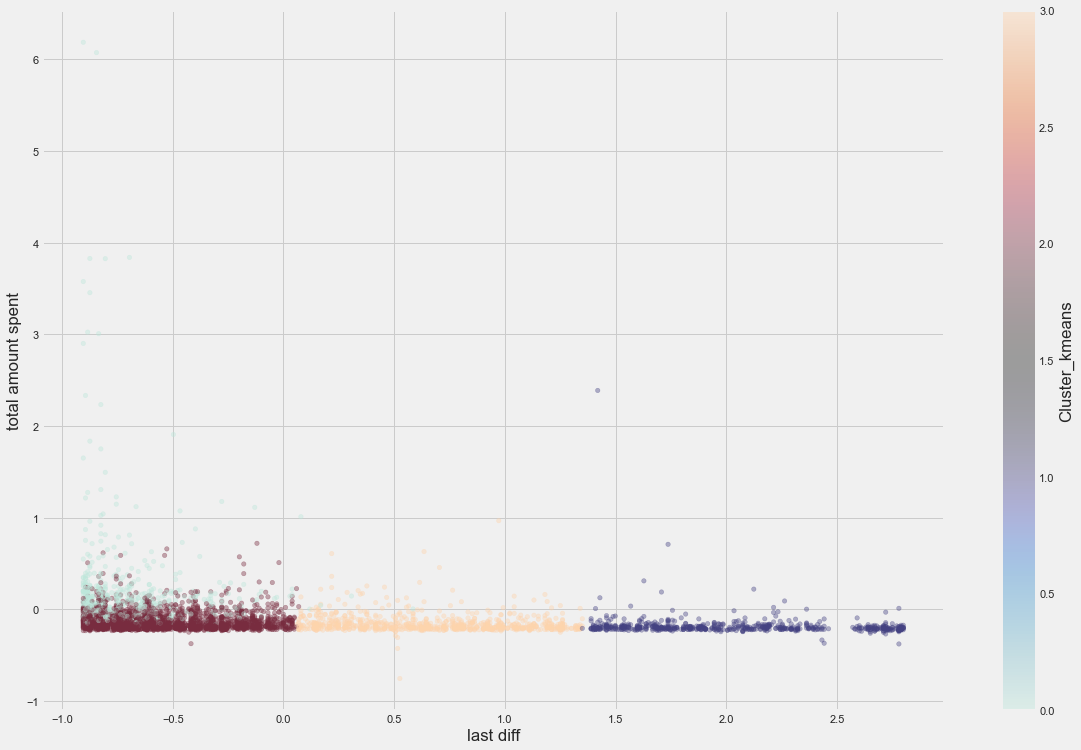

In [63]:
ax = new_df.plot(
    kind="scatter", 
    x="last diff", 
    y="total amount spent", 
    figsize=(18,12),
    c="Cluster_kmeans", 
    cmap=plt.get_cmap("icefire"),
    colorbar=True, 
    alpha=0.4,
)

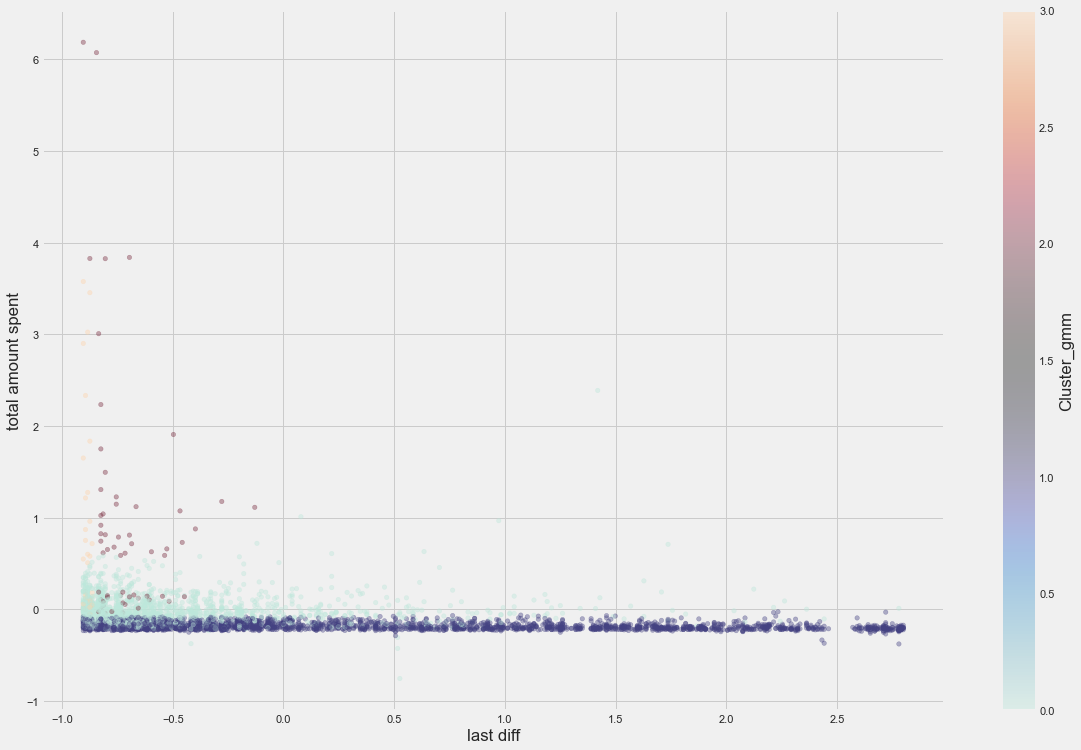

In [64]:
ax = new_df.plot(
    kind="scatter", 
    x="last diff", 
    y="total amount spent", 
    figsize=(18,12),
    c="Cluster_gmm", 
    cmap=plt.get_cmap("icefire"),
    colorbar=True, 
    alpha=0.4,
)

### 3D plot of the three features based off of the clusters prediction


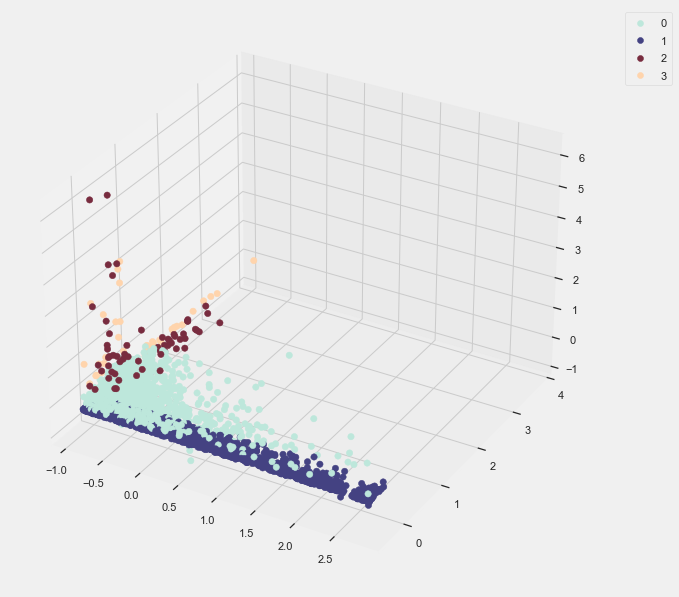

In [65]:
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = [30, 10]
x = new_df['last diff']
y = new_df['Total invoice']
z = new_df['total amount spent']
c = new_df['Cluster_gmm']

fig = plt.figure()
ax = fig.gca(projection='3d')
cmap = ListedColormap(sns.color_palette("icefire", 256).as_hex())
sc = ax.scatter(x, y, z, s=40, c=c, marker='o', cmap=cmap, alpha=1)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show();

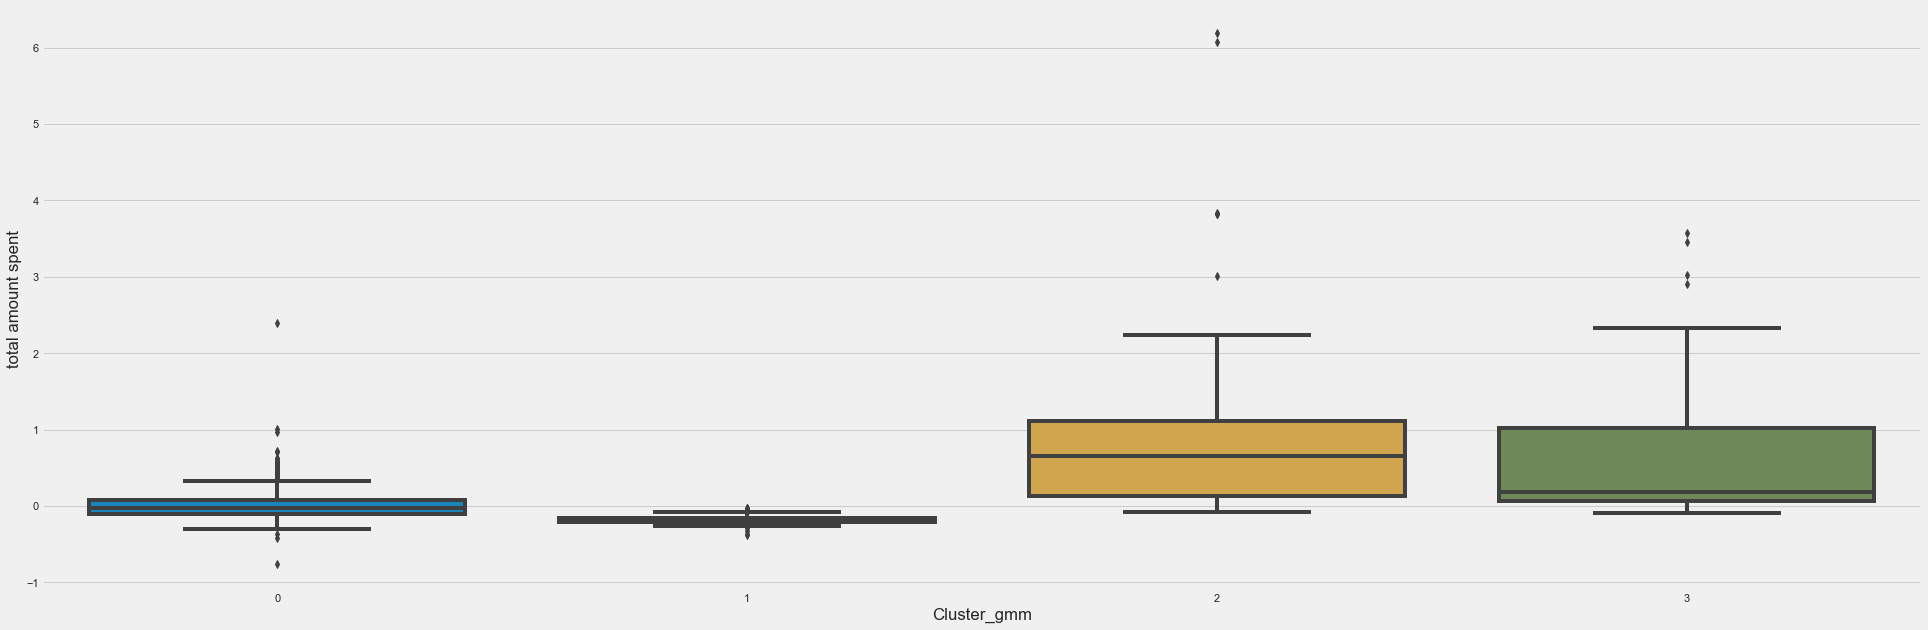

In [66]:
sns.boxplot(x='Cluster_gmm', y='total amount spent', data=new_df);

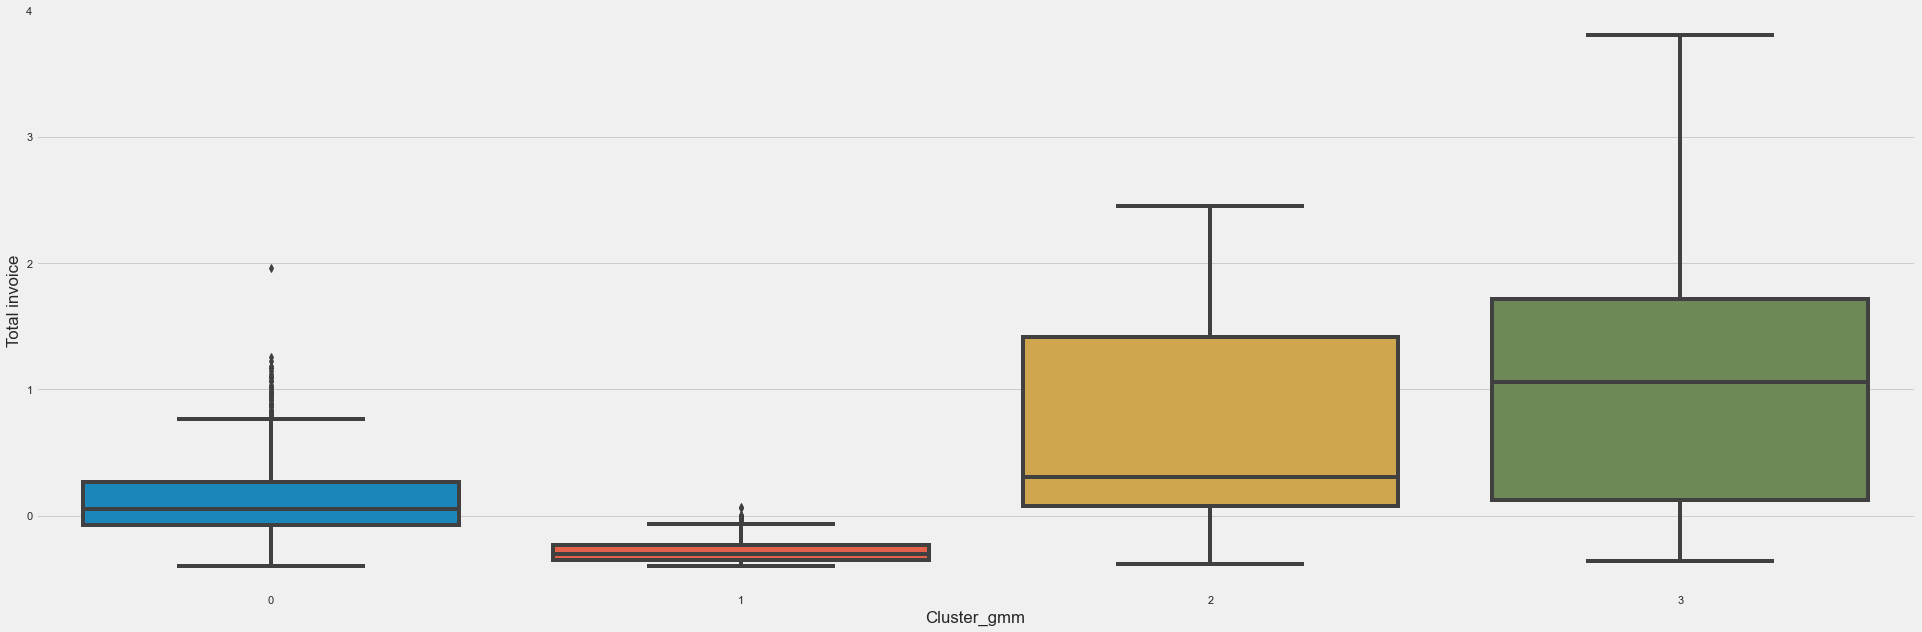

In [68]:
sns.boxplot(x='Cluster_gmm', y='Total invoice', data=new_df);

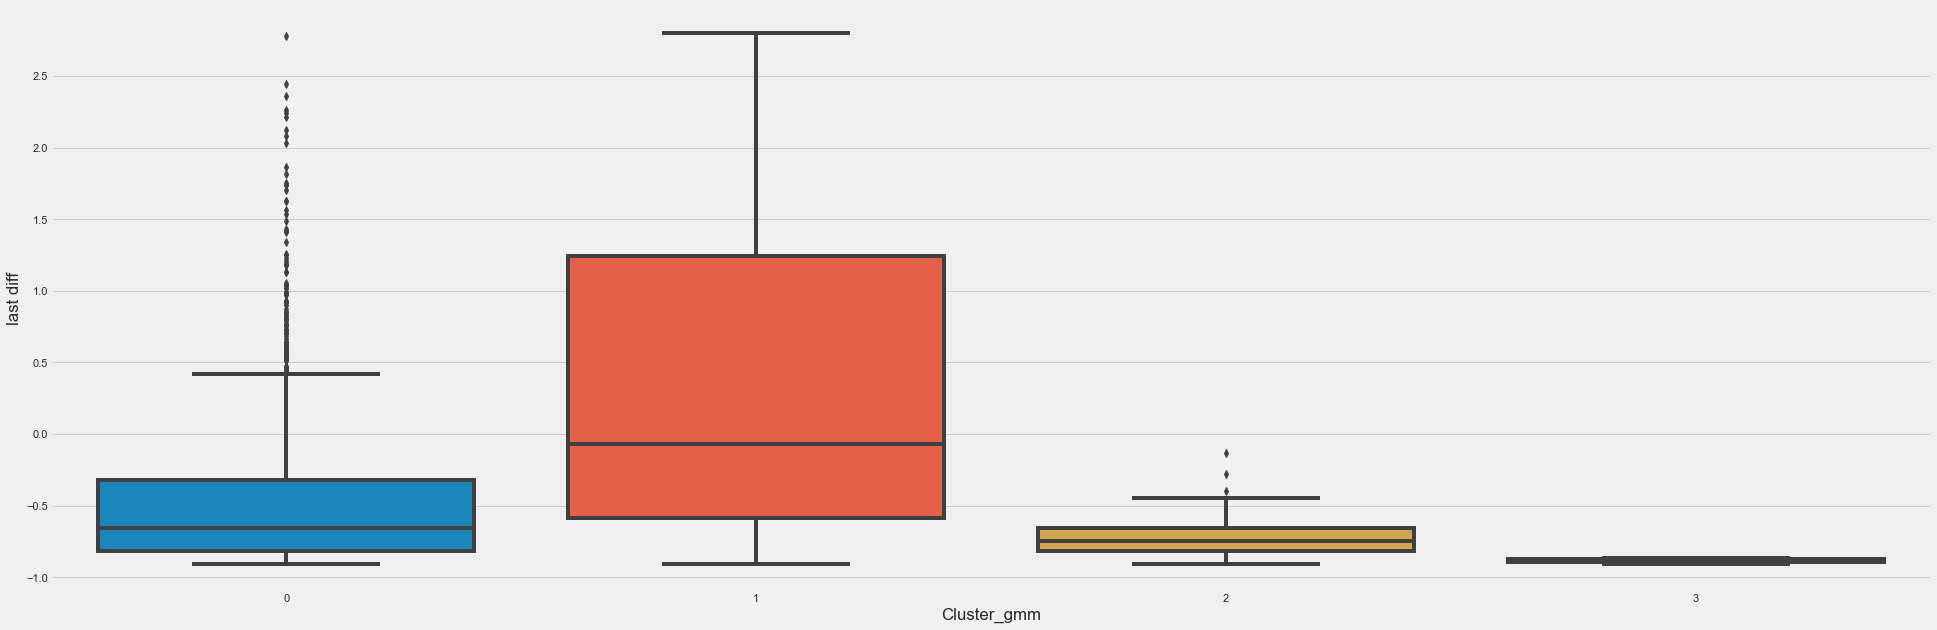

In [69]:
sns.boxplot(x='Cluster_gmm', y='last diff', data=new_df);

___
# CONCLUSION !!

- i looked at the data from different perspective
- first we found few feature that needed some preparations like normalization, droping missing data etc
- we group the data by customer and not as individual since we the goal is customer segmentation 
- `TIMEWISE` : we have observed that arround october there is a peak probably due to some special days/ holidays
- `OUTLIERS` : we use a method to find the outlier after we scalled them so the value dont affect the algo and put them under 'outlier' if no need - then we drop all the indices that were found as outlier 
- `ALGO` : i use diff method such as gmm , silhouette , elbow in order to found the best number of cluster, i also explain why each algo is better and i found that gmm give us the best score also we can observe it in the plots
- ` finally` after ploting each feature based on the cluster we found that some cluster has higher value than other which gave importance how we choose the number of cluster . for example cluster one have much higher value in the number of diff days than other cluster, also total invoices having also higher value in cluster 0 than other

**to conclude i found that project very interessting, using many differents methods (like timeseries) and other that i didnt know before, of course lot of job can be added in order to get much better understanding, thanks to many hours of reading towarddatascience /medium , youtube i understand more the idea of clustering-  hope you enjoy as much as i did by doing the project**